### Проект по курсу "Прикладные аспекты нелинейной науки"

**Корнилова Светлана, группа ББИ154**

**ЗАДАЧА**

Написать функцию, которая генерирует стохастический процесс, заданный уравнением:

$$dx = \sigma^2 (\mu - \frac{\nu}{2}) x^{2\mu-1}dt + \sigma x^\mu dW$$

Это уравнение (1) из статьи J. Ruseckas, B. Kaulakys ["1/f noise from nonlinear stochastic differential equations"](https://arxiv.org/abs/1002.4316).

**РЕШЕНИЕ**

Сначала импортируем необходимые библиотеки:

In [1]:
import math
import numpy
import random
import decimal
import scipy.linalg
import numpy.random as nrand
import matplotlib.pyplot as plt

Создадим класс и определим параметры модели:

In [23]:
class ModelParameters:
    """
    Encapsulates model parameters
    """

    def __init__(self,
                 all_s0, all_time, all_delta, all_sigma, cir_a=0.0, cir_mu=0.0, all_r0=0.0, sde_nu=0.0, sde_mu=0.0, sde_sigma=0.0):
        # This is the starting asset value
        self.all_s0 = all_s0
        # This is the amount of time to simulate for
        self.all_time = all_time
        # This is the delta, the rate of time e.g. 1/252 = daily, 1/12 = monthly
        self.all_delta = all_delta
        # This is the volatility of the stochastic processes
        self.all_sigma = all_sigma
    
        # This is the rate of mean reversion for Cox Ingersoll Ross
        self.cir_a = cir_a
        # This is the long run average interest rate for Cox Ingersoll Ross
        self.cir_mu = cir_mu
        # This is the starting interest rate value
        self.all_r0 = all_r0
        
        self.sde_nu = sde_nu
        self.sde_mu = sde_mu
        self.sde_sigma = sde_sigma

In [25]:
mp = ModelParameters(all_s0=1000,
                     all_r0=0.5,
                     all_time=800,
                     all_delta=0.00396825396,
                     all_sigma=0.125,
                     
                     cir_a=3.0,
                     cir_mu=0.5,
                     
                     sde_nu=0.2,
                     sde_mu=0.5,
                     sde_sigma=0.125)

paths = 15

Функция для построения графика стохастического процесса:

In [3]:
def plot_stochastic_processes(processes, title):
    """
    This method plots a list of stochastic processes with a specified title
    :return: plots the graph of the two
    """
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    fig.suptitle(title, fontsize=16)
    ax.set_xlabel('Time, t')
    ax.set_ylabel('Simulated Asset Price')
    x_axis = numpy.arange(0, len(processes[0]), 1)
    for i in range(len(processes)):
        plt.plot(x_axis, processes[i])
    plt.show()

Функции для обработки возращаемых параметров:

In [4]:
def convert_to_returns(log_returns):
    """
    This method exponentiates a sequence of log returns to get daily returns.
    :param log_returns: the log returns to exponentiated
    :return: the exponentiated returns
    """
    return numpy.exp(log_returns)


def convert_to_prices(param, log_returns):
    """
    This method converts a sequence of log returns into normal returns (exponentiation) and then computes a price
    sequence given a starting price, param.all_s0.
    :param param: the model parameters object
    :param log_returns: the log returns to exponentiated
    :return:
    """
    returns = convert_to_returns(log_returns)
    # A sequence of prices starting with param.all_s0
    price_sequence = [param.all_s0]
    for i in range(1, len(returns)):
        # Add the price at t-1 * return at t
        price_sequence.append(price_sequence[i - 1] * returns[i - 1])
    return numpy.array(price_sequence)

In [9]:
def brownian_motion_log_returns(param):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion. For more information
    about the Wiener process check out the Wikipedia page: http://en.wikipedia.org/wiki/Wiener_process
    :param param: the model parameters object
    :return: brownian motion log returns
    """
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    return nrand.normal(loc=0, scale=sqrt_delta_sigma, size=param.all_time)

def brownian_motion_levels(param):
    """
    Returns a price sequence whose returns evolve according to a brownian motion
    :param param: model parameters object
    :return: returns a price sequence which follows a brownian motion
    """
    return convert_to_prices(param, brownian_motion_log_returns(param))

Пример генерации The Cox Ingersoll Ross (CIR) стохастического процесса, заданного уравнением:

$$dr_t = a (b-r_t) dt + \sigma \sqrt{r_t} dW$$

In [17]:
def cox_ingersoll_ross_levels(param):
    """
    This method returns the rate levels of a mean-reverting cox ingersoll ross process. It is used to model interest
    rates as well as stochastic volatility in the Heston model. Because the returns between the underlying and the
    stochastic volatility should be correlated we pass a correlated Brownian motion process into the method from which
    the interest rate levels are constructed. The other correlated process is used in the Heston model
    :param param: the model parameters object
    :return: the interest rate levels for the CIR process
    """
    brownian_motion = brownian_motion_log_returns(param)
    # Setup the parameters for interest rates
    a, mu, zero = param.cir_a, param.cir_mu, param.all_r0
    # Assumes output is in levels
    levels = [zero]
    for i in range(1, param.all_time):
        drift = a * (mu - levels[i-1]) * param.all_delta
        # The main difference between this and the Ornstein Uhlenbeck model is that we multiply the 'random'
        # component by the square-root of the previous level i.e. the process has level dependent interest rates.
        randomness = math.sqrt(levels[i - 1]) * brownian_motion[i - 1]
        levels.append(levels[i - 1] + drift + randomness)
    return numpy.array(levels)

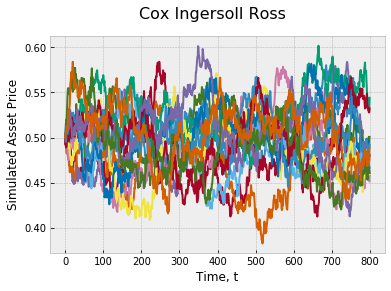

In [18]:
cir_examples = []
for i in range(paths):
    cir_examples.append(cox_ingersoll_ross_levels(mp))
plot_stochastic_processes(cir_examples, "Cox Ingersoll Ross")

Генерация стохастического процесса, заданного уравнением: 

$$dx = \sigma^2 (\mu - \frac{\nu}{2}) x^{2\mu-1}dt + \sigma x^\mu dW$$

In [28]:
def sde_levels(param):
  
    brownian_motion = brownian_motion_log_returns(param)
    # Setup the parameters
    mu, nu, sigma, zero = param.sde_mu, param.sde_nu, param.all_sigma, param.all_r0
    # Assumes output is in levels
    levels = [zero]
    for i in range(1, param.all_time):
        drift = (sigma**2) * (mu - nu/2) * (levels[i-1]**(2*mu-1)) * param.all_delta
        randomness = (levels[i - 1]**mu) * brownian_motion[i - 1]
        levels.append(levels[i - 1] + drift + randomness)
    return numpy.array(levels)

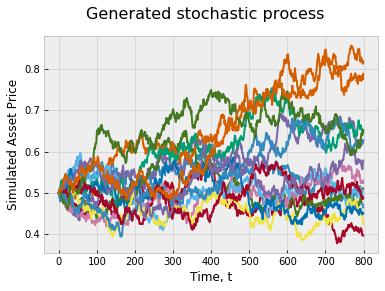

In [34]:
sde_examples = []
for i in range(paths):
    sde_examples.append(sde_levels(mp))
plot_stochastic_processes(sde_examples, "Generated stochastic process")